In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from pykrige.ok import OrdinaryKriging
import pickle
import os

def xgboost_kriging_prediction(df, label_col, feature_cols, coord_cols, param_grid, save_model_path):
    # 分离特征和标签
    X = df[feature_cols + coord_cols]
    y = df[label_col]
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 初始化XGBoost回归器
    xgb = XGBRegressor(random_state=42)
    
    # 迭代特征优化
    selector = RFECV(xgb, step=1, cv=5)
    selector = selector.fit(X_train[feature_cols], y_train)
    X_train_selected = selector.transform(X_train[feature_cols])
    X_test_selected = selector.transform(X_test[feature_cols])
    
    # 获取选择的特征
    selected_features = np.array(feature_cols)[selector.support_]
    print(f"Selected features: {selected_features}")
    
    # 初步超参数搜索（随机搜索）
    n_iter_search = 50
    random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=n_iter_search, cv=5, random_state=42, n_jobs=-1, verbose=2)
    random_search.fit(X_train_selected, y_train)
    
    # 基于随机搜索结果的超参数范围
    best_params = random_search.best_params_
    print(f"Random search best params: {best_params}")
    
    param_grid_fine = {
        'n_estimators': [max(10, best_params['n_estimators'] - 50), best_params['n_estimators'], min(1000, best_params['n_estimators'] + 50)],
        'max_depth': [max(1, best_params['max_depth'] - 2), best_params['max_depth'], best_params['max_depth'] + 2],
        'learning_rate': [best_params['learning_rate'] / 2, best_params['learning_rate'], best_params['learning_rate'] * 2],
        'subsample': [max(0.1, best_params['subsample'] - 0.1), best_params['subsample'], min(1, best_params['subsample'] + 0.1)]
    }
    
    # 精细超参数搜索（网格搜索）
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid_fine, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_selected, y_train)
    
    # 最优参数
    best_params = grid_search.best_params_
    best_xgb = grid_search.best_estimator_
    
    # 特征重要性
    feature_importances = best_xgb.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    # 保存特征重要性
    importance_df.to_csv(os.path.join(os.path.dirname(save_model_path), 'feature_importance.csv'), index=False)
    
    # 绘制特征重要性图
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.savefig(os.path.join(os.path.dirname(save_model_path), 'feature_importance.png'))
    
    # 预测与评估
    y_train_pred = best_xgb.predict(X_train_selected)
    y_test_pred = best_xgb.predict(X_test_selected)
    
    r2_xgb = r2_score(y_test, y_test_pred)
    mae_xgb = mean_absolute_error(y_test, y_test_pred)
    mse_xgb = mean_squared_error(y_test, y_test_pred)
    rmse_xgb = np.sqrt(mse_xgb)
    
    # 输出XGBoost评估分数
    print(f"XGBoost R2: {r2_xgb}")
    print(f"XGBoost MAE: {mae_xgb}")
    print(f"XGBoost MSE: {mse_xgb}")
    print(f"XGBoost RMSE: {rmse_xgb}")
    
    # 计算残差
    residuals_train = y_train - y_train_pred
    
    # 克里金残差训练
    OK = OrdinaryKriging(X_train[coord_cols[0]], X_train[coord_cols[1]], residuals_train, variogram_model='spherical')
    kriging_predictions_test, _ = OK.execute('points', X_test[coord_cols[0]], X_test[coord_cols[1]])
    
    # 最终预测
    predictions_test = y_test_pred + kriging_predictions_test
    
    # 计算克里金残差评估分数
    r2_xk = r2_score(y_test, predictions_test)
    mae_xk = mean_absolute_error(y_test, predictions_test)
    mse_xk = mean_squared_error(y_test, predictions_test)
    rmse_xk = np.sqrt(mse_xk)
    
    # 输出克里金残差评估分数
    print(f"XGBoost-Kriging R2: {r2_xk}")
    print(f"XGBoost-Kriging MAE: {mae_xk}")
    print(f"XGBoost-Kriging MSE: {mse_xk}")
    print(f"XGBoost-Kriging RMSE: {rmse_xk}")
    
    # 绘制评估分数图
    plt.figure(figsize=(10, 6))
    metrics = ['R2', 'MAE', 'MSE', 'RMSE']
    values_xgb = [r2_xgb, mae_xgb, mse_xgb, rmse_xgb]
    values_xk = [r2_xk, mae_xk, mse_xk, rmse_xk]

    # XGBoost评估分数图
    plt.subplot(2, 1, 1)
    bars_xgb = plt.bar(metrics, values_xgb)
    plt.ylabel('Scores')
    plt.title('XGBoost Evaluation Scores')

    # 在条形图上标注值
    for bar, value in zip(bars_xgb, values_xgb):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', ha='center', va='bottom')

    # XGBoost-Kriging评估分数图
    plt.subplot(2, 1, 2)
    bars_xk = plt.bar(metrics, values_xk)
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('XGBoost-Kriging Evaluation Scores')

    # 在条形图上标注值
    for bar, value in zip(bars_xk, values_xk):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(os.path.dirname(save_model_path), 'evaluation_scores.png'))
    
    # 保存模型
    with open(save_model_path, 'wb') as f:
        pickle.dump(best_xgb, f)
    
    return {
        "SelectedFeatures": selected_features,
        "FeatureImportance": importance_df,
        "XGBoost": {
            "R2": r2_xgb,
            "MAE": mae_xgb,
            "MSE": mse_xgb,
            "RMSE": rmse_xgb
        },
        "XGBoostKriging": {
            "R2": r2_xk,
            "MAE": mae_xk,
            "MSE": mse_xk,
            "RMSE": rmse_xk
        }
    }

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from pykrige.ok import OrdinaryKriging
import pickle
import os

def preprocess_data(df, feature_cols, coord_cols):
    # 识别分类变量
    categorical_columns = df[feature_cols].select_dtypes(include=['category']).columns
    
    # 使用LabelEncoder将分类变量转换为数值
    df_encoded = df.copy()
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le
    
    return df_encoded, label_encoders, categorical_columns

def xgb_classics(df, label_col, feature_cols, coord_cols, param_grid, save_model_path):
    # 预处理数据
    df_encoded, label_encoders, categorical_columns = preprocess_data(df, feature_cols, coord_cols)
    
    X = df_encoded[feature_cols + coord_cols]
    y = df_encoded[label_col]
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 初步超参数搜索（随机搜索）
    xgb = XGBRegressor(random_state=42)
    n_iter_search = 100
    random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=n_iter_search, cv=5, random_state=42, n_jobs=-1, verbose=2)
    random_search.fit(X_train, y_train)
    
    # 打印最佳参数
    best_random_params = random_search.best_params_
    print('Best Random Parameters: \n', best_random_params)
    
    # 使用最佳参数对测试集进行评估
    best_random_xgb = random_search.best_estimator_
    test_random_score = best_random_xgb.score(X_test, y_test)
    train_random_score = best_random_xgb.score(X_train, y_train)

    print('RandomSearch Test accuracy:', test_random_score, 'RandomSearch Train accuracy:', train_random_score)
    
    # 基于随机搜索结果的超参数范围
    print(f"Random search best params: {best_random_params}")
    param_grid_fine = {
        'n_estimators': [max(10, best_random_params['n_estimators'] - 50), best_random_params['n_estimators'], min(1000, best_random_params['n_estimators'] + 50)],
        'max_depth': [max(1, best_random_params['max_depth'] - 2), best_random_params['max_depth'], min(10, best_random_params['max_depth'] + 2)],
        'learning_rate': [best_random_params['learning_rate'] / 2, best_random_params['learning_rate'], best_random_params['learning_rate'] * 2],
        'subsample': [max(0.5, best_random_params['subsample'] - 0.1), best_random_params['subsample'], min(1.0, best_random_params['subsample'] + 0.1)]
    }
    
    # 精细超参数搜索（网格搜索）
    grid_search = GridSearchCV(estimator=best_random_xgb, param_grid=param_grid_fine, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # 最优参数
    best_gr_params = grid_search.best_params_
    best_gr_xgb = grid_search.best_estimator_
    
    # 打印最佳参数
    print('Best Grid Parameters: \n', best_gr_params)
    
    # 使用最佳参数对测试集进行评估
    test_gr_score = best_gr_xgb.score(X_test, y_test)
    train_gr_score = best_gr_xgb.score(X_train, y_train)
    print('GridSearch Test accuracy:', test_gr_score, 'GridSearch Train accuracy:', train_gr_score)
    
    # 特征重要性
    feature_gr_importances = best_gr_xgb.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_gr_importances
    }).sort_values(by='Importance', ascending=False)
    
    # 保存特征重要性
    importance_df.to_csv(os.path.join(os.path.dirname(save_model_path), 'feature_importance.csv'), index=False)
    
    # 绘制特征重要性图
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.savefig(os.path.join(os.path.dirname(save_model_path), 'feature_importance.png'))
    
    # 预测与评估
    y_train_pred = best_gr_xgb.predict(X_train)
    y_test_pred = best_gr_xgb.predict(X_test)
    
    r2_xgb = r2_score(y_test, y_test_pred)
    mae_xgb = mean_absolute_error(y_test, y_test_pred)
    mse_xgb = mean_squared_error(y_test, y_test_pred)
    rmse_xgb = np.sqrt(mse_xgb)
    
    # 输出XGBoost评估分数
    print(f"XGBoost R2: {r2_xgb}")
    print(f"XGBoost MAE: {mae_xgb}")
    print(f"XGBoost MSE: {mse_xgb}")
    print(f"XGBoost RMSE: {rmse_xgb}")
    
    # 计算残差
    residuals_train = y_train - y_train_pred
    
    # 克里金残差训练
    OK = OrdinaryKriging(X_train[coord_cols[0]], X_train[coord_cols[1]], residuals_train, variogram_model='spherical')
    kriging_predictions_test, _ = OK.execute('points', X_test[coord_cols[0]], X_test[coord_cols[1]])
    
    # 最终预测
    predictions_test = y_test_pred + kriging_predictions_test
    
    # 计算克里金残差评估分数
    r2_xk = r2_score(y_test, predictions_test)
    mae_xk = mean_absolute_error(y_test, predictions_test)
    mse_xk = mean_squared_error(y_test, predictions_test)
    rmse_xk = np.sqrt(mse_xk)
    
    # 输出克里金残差评估分数
    print(f"XGBoost-Kriging R2: {r2_xk}")
    print(f"XGBoost-Kriging MAE: {mae_xk}")
    print(f"XGBoost-Kriging MSE: {mse_xk}")
    print(f"XGBoost-Kriging RMSE: {rmse_xk}")
    
    # 绘制评估分数图
    plt.figure(figsize=(10, 6))
    metrics = ['R2', 'MAE', 'MSE', 'RMSE']
    values_xgb = [r2_xgb, mae_xgb, mse_xgb, rmse_xgb]
    values_xk = [r2_xk, mae_xk, mse_xk, rmse_xk]

    # XGBoost评估分数图
    plt.subplot(2, 1, 1)
    bars_xgb = plt.bar(metrics, values_xgb)
    plt.ylabel('Scores')
    plt.title('XGBoost Evaluation Scores')

    # 在条形图上标注值
    for bar, value in zip(bars_xgb, values_xgb):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05 * (max(values_xgb) - min(values_xgb)), 
                f'{value:.2f}', ha='center', va='bottom')

    # XGBoost-Kriging评估分数图
    plt.subplot(2, 1, 2)
    bars_xk = plt.bar(metrics, values_xk)
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('XGBoost-Kriging Evaluation Scores')

    # 在条形图上标注值
    for bar, value in zip(bars_xk, values_xk):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05 * (max(values_xk) - min(values_xk)), 
                f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(os.path.dirname(save_model_path), 'evaluation_scores.png'))
    
    # 保存模型
    with open(save_model_path, 'wb') as f:
        pickle.dump((best_gr_xgb, label_encoders), f)
    
    return {
        "SelectedFeatures": feature_cols,
        "FeatureImportance": importance_df,
        "XGBoost": {
            "R2": r2_xgb,
            "MAE": mae_xgb,
            "MSE": mse_xgb,
            "RMSE": rmse_xgb
        },
        "XGBoostKriging": {
            "R2": r2_xk,
            "MAE": mae_xk,
            "MSE": mse_xk,
            "RMSE": rmse_xk
        }
    }


In [3]:
# 读取数据
data = pd.read_csv(r"F:\cache_data\pre_property_table\dy\feature_ph_dy.csv")
print(len(data))
# 删除有缺失值的行
# data.dropna(inplace=True)
# len(data),data.columns

# 选择数值列并计算它们的均值
numeric_cols = data.select_dtypes(include=[np.number])
means = numeric_cols.mean()
# 使用均值填充每个数值列的缺失值
data[numeric_cols.columns] = data[numeric_cols.columns].fillna(means)

1159


In [4]:
data['DL'] = data['DL'].astype("category")
data['DZ'] = data['DZ'].astype("category")
data['SlopeClass'] = data['SlopeClass'].astype("category")
# 用户上传的DataFrame
df = data


ph
(1159, 98)
(1159, 98)
(927, 42) (232, 42) (927,) (232,)
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Random Parameters: 
 {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.01}
RandomSearch Test accuracy: 0.26809469101141037 RandomSearch Train accuracy: 0.6549115305054474
Random search best params: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.01}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Grid Parameters: 
 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.5}
GridSearch Test accuracy: 0.27486844447579883 GridSearch Train accuracy: 0.6471377428256715
XGBoost R2: 0.27486844447579883
XGBoost MAE: 0.6385205067437272
XGBoost MSE: 0.6899216115969352
XGBoost RMSE: 0.8306152006777477
XGBoost-Kriging R2: 0.2708539791368092
XGBoost-Kriging MAE: 0.6472443953744764
XGBoost-Kriging MSE: 0.6937411480317737
XGBoost-Kriging RMSE: 0.8329112485924137
{'SelectedFeatures': ['DE

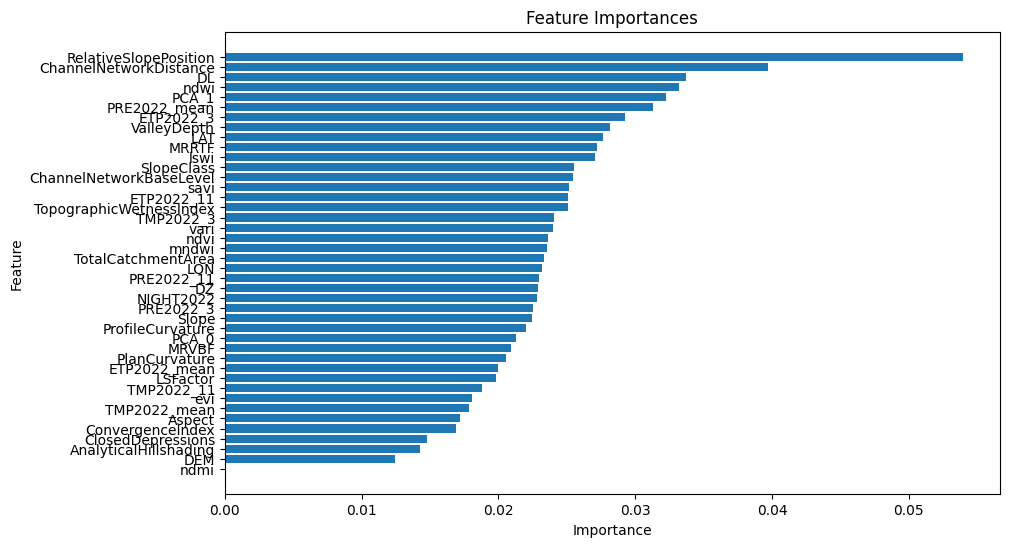

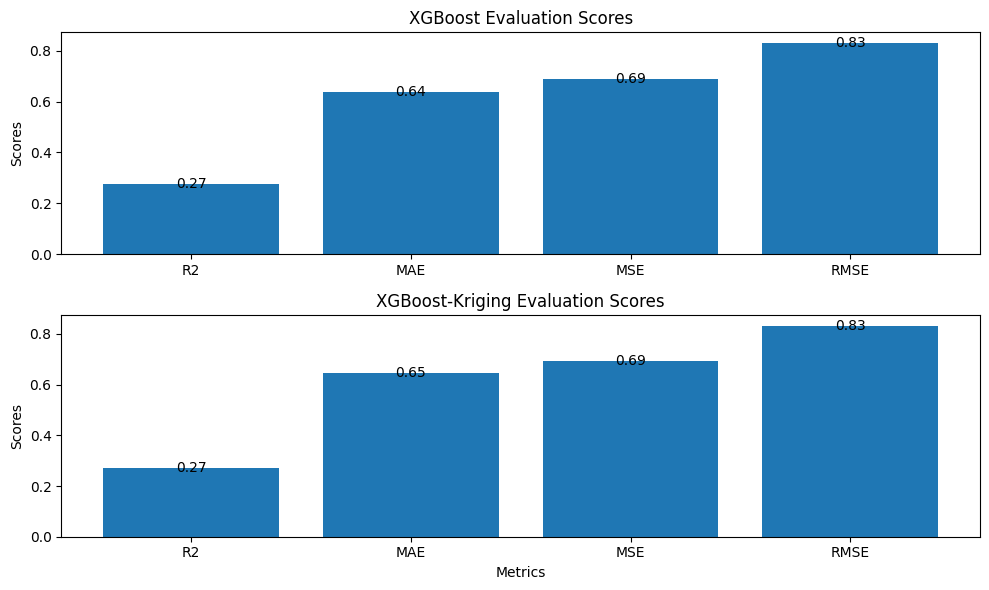

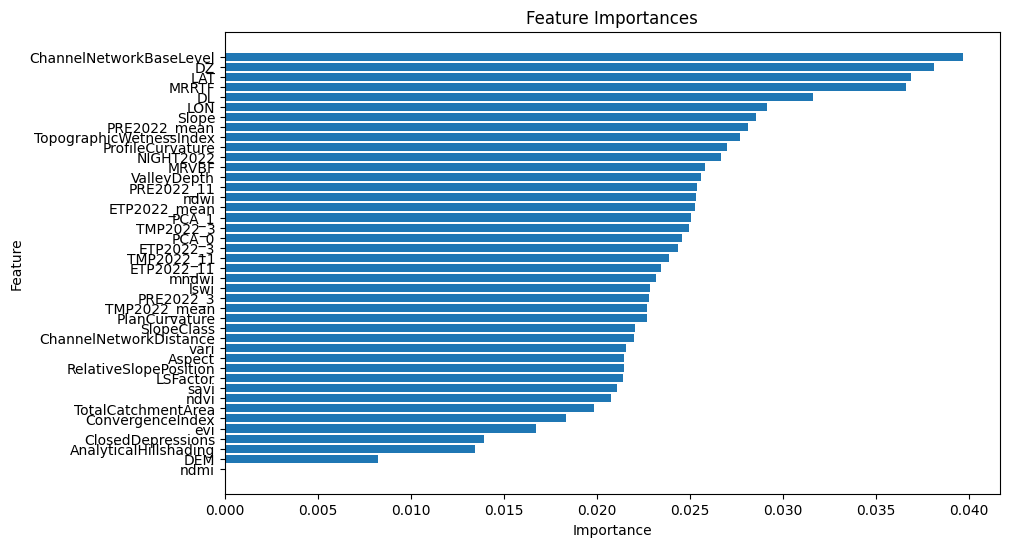

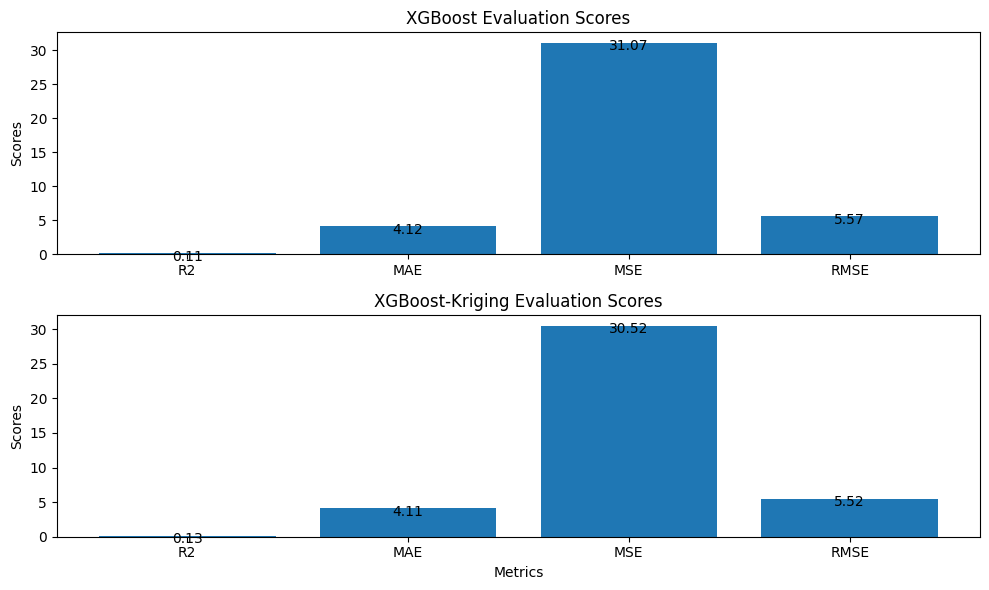

In [5]:
coord_cols = ["LON", "LAT"]
# 用户选择的标签列和特征列
# label_col = "ph"
feature_cols = ['DEM', 'AnalyticalHillshading', 'Aspect',
       'ChannelNetworkBaseLevel', 'ChannelNetworkDistance',
       'ClosedDepressions', 'ConvergenceIndex', 'LSFactor', 'MRRTF', 'MRVBF',
       'PlanCurvature', 'ProfileCurvature', 'RelativeSlopePosition', 'Slope',
       'TopographicWetnessIndex', 'TotalCatchmentArea', 'ValleyDepth',
       'NIGHT2022', 'ETP2022_mean', 'TMP2022_mean', 'PRE2022_mean',
       'PRE2022_3', 'PRE2022_11', 'ETP2022_3', 'ETP2022_11', 'TMP2022_3',
       'TMP2022_11', 'evi', 'lswi', 'mndwi', 'ndmi', 'ndvi', 'ndwi', 'PCA_0',
       'PCA_1', 'savi', 'vari', 'DL', 'DZ','SlopeClass']

# 用户指定的超参数调优范围
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500,600,700,800,900,1000],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]
}
# 逐个训练并导出
# label_cols_list = ['ph', 'ylzjhl', 'yjz', 'qdan', 'qlin', 'qjia', 'qxi', 'yxlin', 'sxjia', 'jxzc11', 'jxzc12', 'jxzc13', 'jxzc14']
label_cols_list = ['ph', 'ylzjhl']
# rf模型目录
rf_dir = r"F:\cache_data\model_path\dy\xgb"
for col in label_cols_list:
    print(col)
    # 选取符合条件的数据
    # pre_data = df[df[f"{col}_Status"]=='Normal']
    print(df.shape)
    pre_data = df[(df[f"{col}"]!=0.0001) & (df[f"{col}"]!=0.0002) & (df[f"{col}_Status"]=='Normal')]
    print(pre_data.shape)
    X = pre_data[feature_cols+coord_cols]
    y = pre_data[col]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    # 输出训练集和测试集的形状
    print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
    # 模型存放位置,检查是否存在该目录,不存在则创建
    temp_dir_path = os.path.join(rf_dir,col)
    if not os.path.exists(temp_dir_path):
        os.makedirs(temp_dir_path)
    # 模型存放路径
    save_model_path =os.path.join(temp_dir_path,f"{col}_xgb_model.pkl") 
    # 训练模型
    # train_log = xgboost_kriging_prediction(pre_data,col,feature_cols,coord_cols,param_grid,save_model_path)
    train_log = xgb_classics(pre_data,col,feature_cols,coord_cols,param_grid,save_model_path)
    print(train_log)